In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import f_oneway  # ANOVA
from sklearn.preprocessing import OneHotEncoder #OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import joblib

In [69]:
# Paso 1: Cargar datos
data = pd.read_csv('train.csv')   # load the data
#Primeras filas del dataset:
print(data.head())


   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [70]:
# Paso 2: Exploraci√≥n inicial de los datos
print("\nInformaci√≥n general del dataset:")
print("\nN√∫mero de variables:", data.shape[1])
print("Cantidad de variables categ√≥ricas: ", data.select_dtypes(include=[object]).shape[1])
print("Cantidad de variables num√©ricas: ", data.select_dtypes(include=[np.number]).shape[1])
print("N√∫mero de observaciones:", data.shape[0])
# Separar variables num√©ricas y categ√≥ricas
num_features = data.select_dtypes(include=[np.number]).columns.tolist()
cat_features = data.select_dtypes(include=['object']).columns.tolist()

# Definir la variable objetivo
target = "SalePrice"



Informaci√≥n general del dataset:

N√∫mero de variables: 81
Cantidad de variables categ√≥ricas:  43
Cantidad de variables num√©ricas:  38
N√∫mero de observaciones: 1460


In [71]:
print("\nEstad√≠sticas descriptivas del dataset:")
print(data.describe())


Estad√≠sticas descriptivas del dataset:
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904   

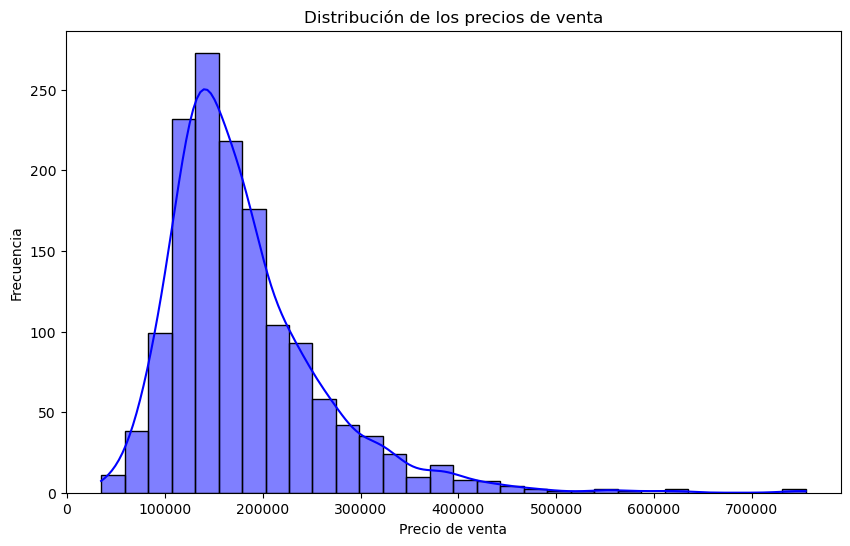

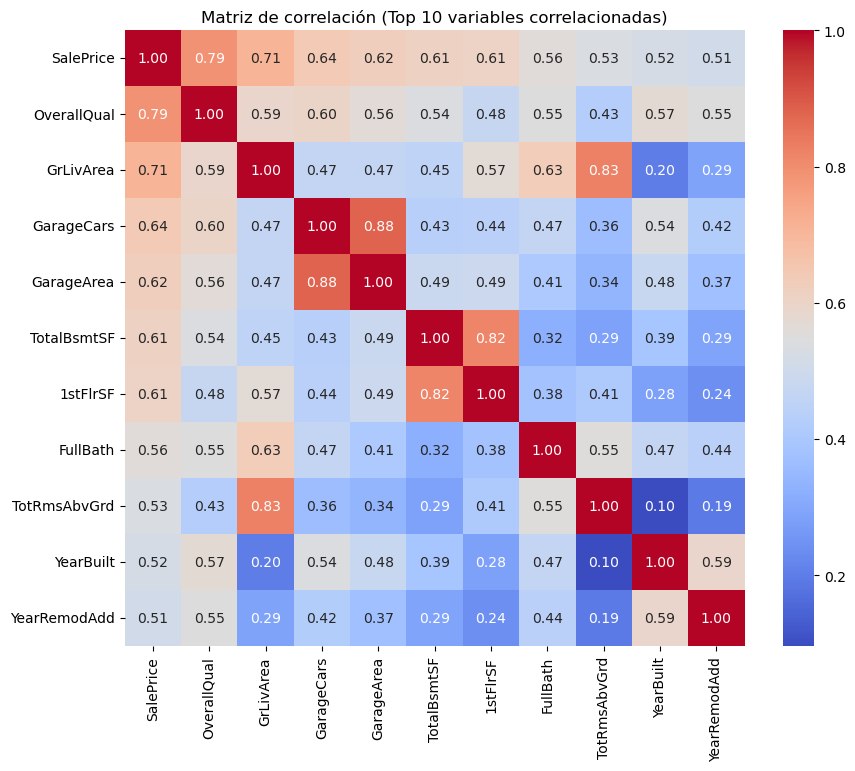

In [72]:
# Paso 3: An√°lisis exploratorio de los Datos

# Histograma que muestra la distribuci√≥n del precio de venta. 
plt.figure(figsize=(10, 6))
sns.histplot(data['SalePrice'], kde=True, bins=30, color='blue')
plt.title("Distribuci√≥n de los precios de venta")
plt.xlabel("Precio de venta")
plt.ylabel("Frecuencia")
plt.show()

# Calcular la correlaci√≥n de SalePrice con otras caracter√≠sticas
correlation_matrix = data[num_features].corr()
saleprice_correlation = correlation_matrix[target].sort_values(ascending=False)

# Visualizaci√≥n de la matriz de correlaci√≥n (top 10 correlaciones)
plt.figure(figsize=(10, 8))
selected_features = saleprice_correlation.head(11).index
sns.heatmap(data[selected_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlaci√≥n (Top 10 variables correlacionadas)")
plt.show()


In [73]:
# Evaluaci√≥n de Variables Categ√≥ricas con ANOVA
anova_results = {}
for cat in cat_features:
    if data[cat].nunique() > 1:  # Evita columnas con un solo valor
        groups = [data[data[cat] == category][target] for category in data[cat].unique()]
        if all(len(group) > 1 for group in groups):  # Asegurar que hay m√°s de una observaci√≥n
            anova_results[cat] = f_oneway(*groups).pvalue

# Ordenar por significancia estad√≠stica
anova_results = {k: v for k, v in sorted(anova_results.items(), key=lambda item: item[1])}

# Convertir a DataFrame para mostrar los primeros 10 resultados
anova_df = pd.DataFrame.from_dict(anova_results, orient='index', columns=['p-value'])

#Tabla con los p-values de las variables categ√≥ricas 
print("\nTabla de p-values de las variables categ√≥ricas:")
print(anova_df.head(10))



Tabla de p-values de las variables categ√≥ricas:
                     p-value
Neighborhood   1.558600e-225
ExterQual      1.439551e-204
KitchenQual    3.032213e-192
Foundation      5.791895e-91
SaleCondition   7.988268e-44
SaleType        5.039767e-42
MSZoning        8.817634e-35
HouseStyle      3.376777e-25
LotShape        6.447524e-25
CentralAir      1.809506e-22


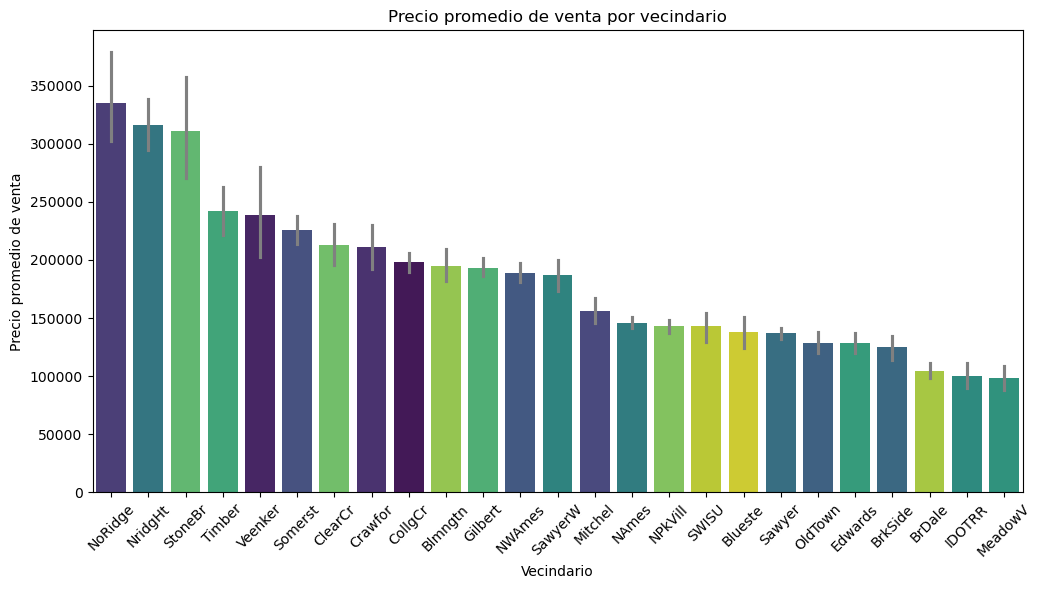

In [82]:
# Paso 4: Visualizaci√≥n de la relaci√≥n entre variables
# Relaci√≥n de Variables Categ√≥ricas con el Precio de la Casa

#Gr√°fico que muestra la distribuci√≥n del precio promedio seg√∫n el vecindario en el que se encuentra: Neighborhood
plt.figure(figsize=(12, 6))
# Calcular el precio promedio por vecindario
neighborhood_order = data.groupby("Neighborhood")["SalePrice"].mean().sort_values(ascending=False).index
sns.barplot(data=data, x="Neighborhood", y="SalePrice", hue = "Neighborhood", palette="viridis", order=neighborhood_order, legend=False, err_kws={'color': '.5'})
plt.xticks(rotation=45)
plt.title("Precio promedio de venta por vecindario")
plt.ylabel("Precio promedio de venta")
plt.xlabel("Vecindario")
plt.show()





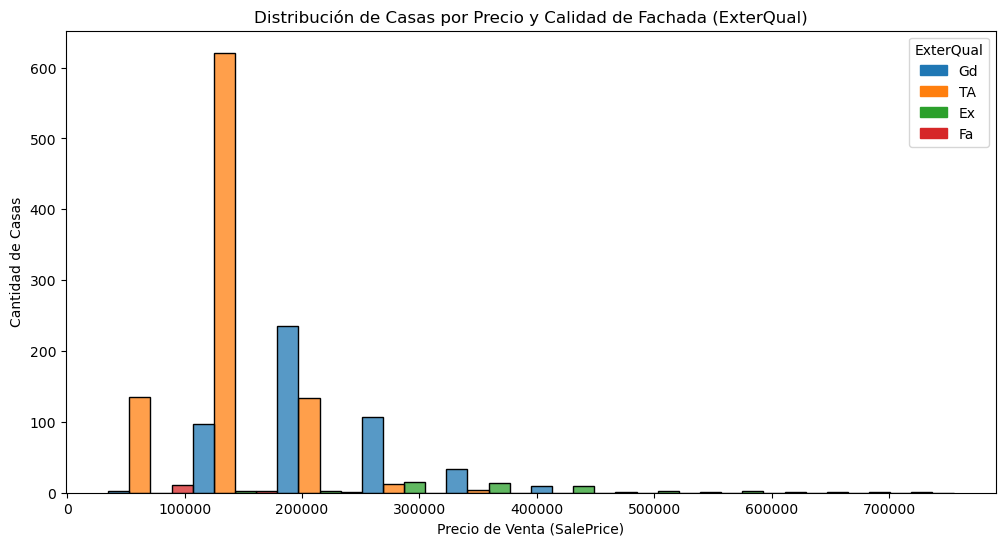

In [83]:

#Distribuci√≥n del precio de las casas seg√∫n la Calidad de su Fachada (ExterQual)
plt.figure(figsize=(12, 6))
# Crear el histograma con diferentes colores por categor√≠a
hist = sns.histplot(data=data, x="SalePrice", hue="ExterQual", bins=10, multiple="dodge", palette="tab10")
# Asegurar que la leyenda solo muestre categor√≠as presentes en los datos
unique_extqual = data["ExterQual"].unique()
colors = sns.color_palette("tab10", len(unique_extqual))
legend_patches = [mpatches.Patch(color=colors[i], label=zone) for i, zone in enumerate(unique_extqual)]

# Agregar leyenda personalizada
plt.legend(handles=legend_patches, title="ExterQual", loc="upper right")
plt.xlabel("Precio de Venta (SalePrice)")
plt.ylabel("Cantidad de Casas")
plt.title("Distribuci√≥n de Casas por Precio y Calidad de Fachada (ExterQual)")
# Mostrar el gr√°fico
plt.show()



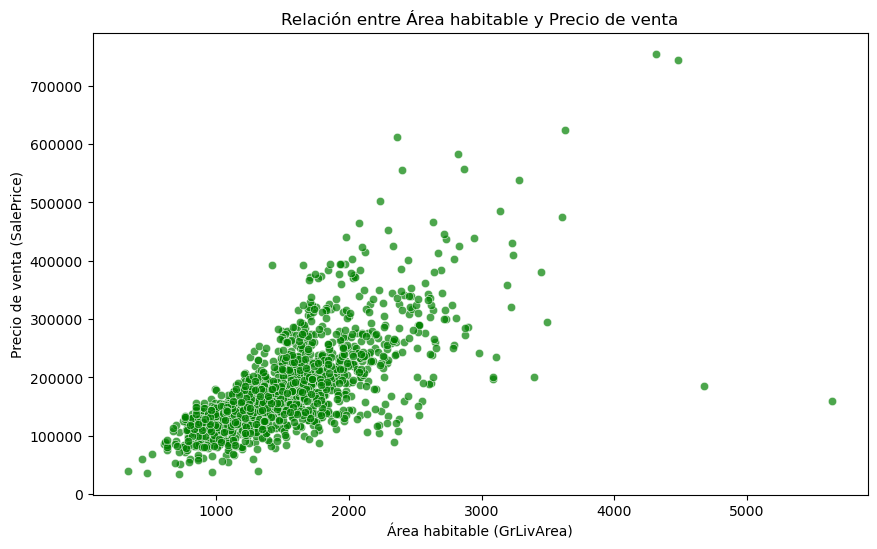

In [84]:

# Relaci√≥n entre 'GrLivArea' (√Årea habitable) y 'SalePrice'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['GrLivArea'], y=data['SalePrice'], alpha=0.7, color='green')
plt.title("Relaci√≥n entre √Årea habitable y Precio de venta")
plt.xlabel("√Årea habitable (GrLivArea)")
plt.ylabel("Precio de venta (SalePrice)")
plt.show()


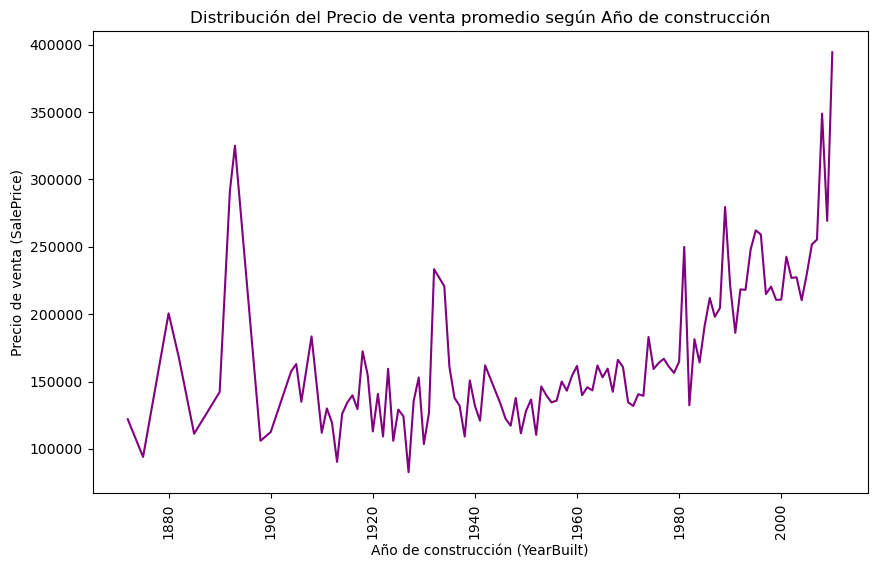

In [85]:
# Relaci√≥n entre 'YearBuilt' (A√±o de construcci√≥n) y 'SalePrice'

#Calculamos el precio de venta promedio para cada a√±o de construcci√≥n
average_price_per_year = data.groupby('YearBuilt')['SalePrice'].mean().reset_index()
#Graficamos la relaci√≥n entre el a√±o de construcci√≥n y el precio de venta promedio
plt.figure(figsize=(10, 6))
sns.lineplot(x=average_price_per_year['YearBuilt'], y=average_price_per_year['SalePrice'], color='purple')
#sns.boxplot(x=data['YearBuilt'], y=data['SalePrice'])
plt.xticks(rotation=90)
plt.title("Distribuci√≥n del Precio de venta promedio seg√∫n A√±o de construcci√≥n")
plt.xlabel("A√±o de construcci√≥n (YearBuilt)")
plt.ylabel("Precio de venta (SalePrice)")
plt.show()


In [86]:


# Paso 6: Preparaci√≥n inicial para modelado

# Selecci√≥n de caracter√≠sticas con alta correlaci√≥n y eliminaci√≥n de variables redundantes
top_num = list(saleprice_correlation.index[:7])  # 7 mejores num√©ricas
top_cat = list(anova_results.keys())[:3]  # 3 mejores categ√≥ricas
selected_features = top_num + top_cat
selected_features.remove(target)  # Eliminar la variable objetivo
print("Variables Seleccionadas:", selected_features)

# Filtrar dataset con las variables seleccionadas
data_model = data[selected_features + [target]]

# Codificar variables categ√≥ricas con OneHotEncoder
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = encoder.fit_transform(data_model[top_cat])
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(top_cat))

# Unir variables codificadas con num√©ricas
final_data = pd.concat([data_model[top_num], encoded_cats_df, data_model[target]], axis=1)

# Separar en entrenamiento y prueba
X = final_data.drop(columns=[target])
y = final_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




Variables Seleccionadas: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'Neighborhood', 'ExterQual', 'KitchenQual']


In [87]:

# Paso 7: Prototipo del modelo Random Forest
# Entrenar modelo Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


# Evaluaci√≥n del modelo
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"üîπ Error Absoluto Medio (MAE): {mae:.2f}")



üîπ Error Absoluto Medio (MAE): 18555.21


In [ ]:
# Paso 8: Inferencia
# Crear una funci√≥n para realizar predicciones con el modelo entrenado
def estimate_price():
    print("\nüîπ Introduce los valores para predecir el precio de la casa:")

    user_input = {}

    for feature in selected_features:
        if feature in cat_features:  # Si es categ√≥rica, ofrecer opciones
            options = data[feature].dropna().unique().tolist()
            value = input(f"{feature} (Opciones: {', '.join(map(str, options))}): ")
            user_input[feature] = value
        else:  # Si es num√©rica, solicitar valor directamente
            min_val = data[feature].min()
            max_val = data[feature].max()
            value = float(input(f"{feature} (Rango Informativp: {min_val} - {max_val}): "))
            user_input[feature] = value

    # Convertir valores categ√≥ricos a one-hot encoding
    user_df = pd.DataFrame([user_input])

    # Asegurar que todas las columnas del modelo est√©n presentes
    user_df = user_df.reindex(columns=X_train.columns, fill_value=0)

    # Predecir precio de la casa
    estimated_price = model.predict(user_df)[0]
    print(f"\n‚úÖ Precio estimado de la casa: ${estimated_price:,.2f}")

# üìå Probar la funci√≥n
estimate_price()

